In [1]:
from osgeo import gdal, ogr
import os
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [4]:
# 10_DAY_COMPOSITE PRECIPITATION ANOMALIY
# get index from tif files
files = listall(r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\TRMM2_2009\10_Day_Period\10_DaySums_StdNormAnomalyRes', extension='.tif')
index = []
for i in files:
    # get date
    year = int(i[-11:-7])
    doy = int(i[-7:-4])
    date = datetime(year, 1, 1) + timedelta(doy - 1)
    date = np.datetime64(date)
    date = pd.Timestamp(np.datetime_as_string(date))
    index.append(date)
index = np.array(index)
print files[0], index[0]

D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\InnerMongolia\TRMM2_2009\10_Day_Period\10_DaySums_StdNormAnomalyRes\TRMM_IM_2009001.tif 2009-01-01 00:00:00+00:00


In [5]:

# get columns from shp file
shp_filename = r'D:\Data\ChinaShapefile//LC_types.shp'
siteID_list = []
ds = ogr.Open(shp_filename)
lyr = ds.GetLayer()
for feat in lyr:
    # get siteID from Field
    siteID = str(feat.GetField('LC_typce'))
    siteID_list.append(siteID)
siteID_array = np.array(siteID_list)
columns = np.unique(siteID_array).astype(str)   

# create empty DataFrame
df = pd.DataFrame(index=index, columns=columns)
#df_shp = pd.DataFrame(index=index, columns=columns)
df.head()

,BA,CO,MC,MV,ON,RC,SV
2009-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
for i in files:
    # load raster GeoTransform, RasterBand    
    try:
        src_ds = gdal.Open(i) 
        gt = src_ds.GetGeoTransform()
        rb = src_ds.GetRasterBand(1)

        # get date
        year = int(i[-11:-7])
        doy = int(i[-7:-4])
        date = datetime(year, 1, 1) + timedelta(doy - 1)
        date = np.datetime64(date)
        date = pd.Timestamp(np.datetime_as_string(date))
        print date
    except Exception, e:
        print e, i
        continue
        
    ds = ogr.Open(shp_filename)
    lyr = ds.GetLayer()
    for feat in lyr:
        try:
            # get siteID from Field

            siteID = str(feat.GetField('LC_typce'))
            #if siteID == '50353':

            # get lon/lat from GeometryRef
            geom = feat.GetGeometryRef()
            mx,my=geom.GetX(), geom.GetY()  #coord in map units

            # convert from map to pixel coordinates.    
            px = int((mx - gt[0]) / gt[1]) #x pixel
            py = int((my - gt[3]) / gt[5]) #y pixel

            # get single pixel
            pixel = rb.ReadAsArray(px,py,1,1)
            #array_ID_nine = np.ma.masked_equal(array_ID_nine, 0)
            #stationID_mean = np.ma.mean(array_ID_nine)
            # stationID_mean = np.nanmean(array_ID_nine)            
            # set pandas dataframe value
            df.ix[date][siteID] = pixel[0][0]
            #print siteID#, px, py, stationID_mean, df.ix[date][siteID]
        except Exception, e:
            #print e, i, feat.GetFID()
            continue            

2009-01-01 00:00:00+00:00
2009-01-02 00:00:00+00:00
2009-01-03 00:00:00+00:00
2009-01-04 00:00:00+00:00
2009-01-05 00:00:00+00:00
2009-01-06 00:00:00+00:00
2009-01-07 00:00:00+00:00
2009-01-08 00:00:00+00:00
2009-01-09 00:00:00+00:00
2009-01-10 00:00:00+00:00
2009-01-11 00:00:00+00:00
2009-01-12 00:00:00+00:00
2009-01-13 00:00:00+00:00
2009-01-14 00:00:00+00:00
2009-01-15 00:00:00+00:00
2009-01-16 00:00:00+00:00
2009-01-17 00:00:00+00:00
2009-01-18 00:00:00+00:00
2009-01-19 00:00:00+00:00
2009-01-20 00:00:00+00:00
2009-01-21 00:00:00+00:00
2009-01-22 00:00:00+00:00
2009-01-23 00:00:00+00:00
2009-01-24 00:00:00+00:00
2009-01-25 00:00:00+00:00
2009-01-26 00:00:00+00:00
2009-01-27 00:00:00+00:00
2009-01-28 00:00:00+00:00
2009-01-29 00:00:00+00:00
2009-01-30 00:00:00+00:00
2009-01-31 00:00:00+00:00
2009-02-01 00:00:00+00:00
2009-02-02 00:00:00+00:00
2009-02-03 00:00:00+00:00
2009-02-04 00:00:00+00:00
2009-02-05 00:00:00+00:00
2009-02-06 00:00:00+00:00
2009-02-07 00:00:00+00:00
2009-02-08 0

In [7]:
df.head()

,BA,CO,MC,MV,ON,RC,SV
2009-01-01 00:00:00+00:00,-0.00379586,-0.0107043,-0.00551759,-0.00433974,-0.0062076,-0.0057721,0.0327611
2009-01-02 00:00:00+00:00,-0.00387202,-0.0103495,-0.00650589,-0.00647727,-0.00749164,-0.00669004,0.0308254
2009-01-03 00:00:00+00:00,-0.00387202,-0.0104704,-0.0060992,-0.00564403,-0.00780279,-0.00699143,0.0260284
2009-01-04 00:00:00+00:00,-0.00438278,-0.0116563,-0.00551835,-0.0032063,-0.00797114,-0.00747954,0.0260284
2009-01-05 00:00:00+00:00,-0.00527951,-0.0168027,-0.00551835,-0.0032063,-0.00765185,-0.0056153,0.0241034


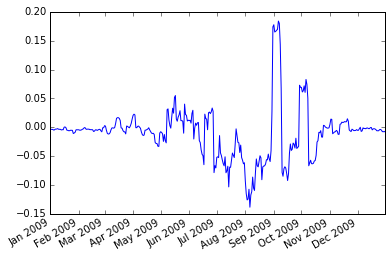

In [14]:
df['BA'].plot()